# Analysis of results from transient-outward Potassium channel ABC calibration

This notebook compares the behaviour of the $I_\text{to}$ current in Nygren, Courtemanche and standardised formulations.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

from typing import List, Union

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyabc import History
from pyabc.weighted_statistics import weighted_mean, weighted_median

import myokit

import pymc3

from ionchannelABC.visualization import plot_variables
from ionchannelABC.utils import weighted_cv

INFO:myokit:Loading Myokit version 1.29.1


## Load pyABC results databases for each run

Assumes that the results databases are stored in a subdirectory called `results'.

Loads history files and converts to dataframes and weights (see pyABC documentation).

In [2]:
def print_results_table(h: History,
                        modelname: str,
                        h_orig: History=None,
                        round_n: int=4,
                        credible_interval: float=0.89,
                        bootstrap_n: int=10000,
                        original: bool=True):
    round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))    
    round_fn = lambda x: round_to_n(x, round_n)
    
    # load df, w for unified and original (if supplied)
    df, w = h.get_distribution()
    if h_orig is not None:
        df_orig, w_orig = h_orig.get_distribution()
    
    params = []
    if original:
        originals = []
    medians = []
    medians_orig = []
    hpd = []
    hpd_orig = []
    rsd = []
    rsd_orig = []

    m = myokit.load_model(modelname)
    
    # need to bootstrap with weights to calculate weighted mean and HPD
    samples = df.sample(n=bootstrap_n, weights=w, replace=True)
    samples = samples.set_index([pd.Index(range(bootstrap_n))])
    
    samples_orig = pd.DataFrame()
    if h_orig is not None:
        samples_orig = df_orig.sample(n=bootstrap_n, weights=w_orig, replace=True)
        samples_orig = samples_orig.set_index([pd.Index(range(bootstrap_n))])
    
    for name in samples.columns:
        params.append(name.split('.')[1])
        if name.startswith('log_'):
            if original:
                originals.append(m.get(name[4:]).value())
            medians.append((10**(samples[name])).median())
            hpd.append(tuple(pymc3.stats.hpd(10**(samples[name]),
                                             credible_interval=credible_interval)))
            if h_orig is not None:
                medians_orig.append((10**(samples_orig[name])).median())
                hpd_orig.append(tuple(pymc3.stats.hpd(10**(samples_orig[name]),
                                                      credible_interval=credible_interval)))
        else:
            if original:
                originals.append(m.get(name).value())
            medians.append(samples[name].median())
            hpd.append(tuple(pymc3.stats.hpd(samples[name],
                                             credible_interval=credible_interval)))
            if h_orig is not None:
                medians_orig.append(samples_orig[name].median())
                hpd_orig.append(tuple(pymc3.stats.hpd(samples_orig[name],
                                                      credible_interval=credible_interval)))
    rsd = weighted_cv(df, w, sample_size=len(df))
    if h_orig is not None:
        rsd_orig = weighted_cv(df_orig, w_orig, sample_size=len(df_orig))
        
    for i, hpd_tuple in enumerate(hpd):
        round_tuple = (round_fn(hpd_tuple[0]),
                       round_fn(hpd_tuple[1]))
        hpd[i] = round_tuple
    for i, hpd_tuple in enumerate(hpd_orig):
        round_tuple = (round_fn(hpd_tuple[0]),
                       round_fn(hpd_tuple[1]))
        hpd_orig[i] = round_tuple
        
    out_dict = {'Name': params}
    if original:
        out_dict = {**out_dict, 'Published': originals}
    if h_orig is not None:
        out_dict = {**out_dict, 'Median (orig)': medians_orig,
                                'HPD'+str(int(credible_interval*100))+' (orig)': hpd_orig,
                                '$log_{10}$RSD (orig)': rsd_orig}
    out_dict = {**out_dict, 'Median (unif)': medians,
                            'HPD'+str(int(credible_interval*100))+' (unif)': hpd,
                            '$log_{10}$RSD (unif)': rsd}
    out_df = pd.DataFrame(out_dict)
    if original:
        out_df['Published'] = out_df['Published'].map(round_fn)
    out_df['Median (unif)'] = out_df['Median (unif)'].map(round_fn)
    out_df['$log_{10}$RSD (unif)'] = np.log10(out_df['$log_{10}$RSD (unif)']).map(round_fn)
    if h_orig is not None:
        out_df['Median (orig)'] = out_df['Median (orig)'].map(round_fn)
        out_df['$log_{10}$RSD (orig)'] = np.log10(out_df['$log_{10}$RSD (orig)']).map(round_fn)

    print(out_df.to_csv(sep='\t', index=False))

#### Nygren

In [3]:
h_nyg_original = History('sqlite:///results/nygren/ito/original/nygren_ito_original.db')
h_nyg_unified = History('sqlite:///results/nygren/ito/unified/nygren_ito_unified.db')

In [4]:
df_nyg_original, w_nyg_original = h_nyg_original.get_distribution(m=0)
df_nyg_unified, w_nyg_unified = h_nyg_unified.get_distribution(m=0)

In [5]:
print_results_table(h_nyg_unified,
                    'models/nygren_ito.mmt',
                    h_orig=h_nyg_original)

Name	Published	Median (orig)	HPD89 (orig)	$log_{10}$RSD (orig)	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p1	1.0	3.207	(0.3701, 6.312)	-0.234	-0.5389	(-7.205, 2.298)	0.4008
p2	11.0	10.32	(7.669, 12.45)	-0.8453	2.204	(1.366, 2.744)	-0.6039
p4	30.0	23.03	(1.571, 45.4)	-0.2055	43.51	(40.83, 46.0)	-1.426
q1	40.5	54.9	(20.77, 88.74)	-0.4189	29.01	(27.81, 30.79)	-1.473
q2	11.5	16.0	(6.2, 22.68)	-0.4416	1.15	(0.3452, 1.969)	-0.3639
q4	52.45	57.85	(50.89, 64.48)	-1.104	38.16	(37.65, 38.63)	-2.083
q5	14.97	12.2	(9.158, 16.54)	-0.7154	16.88	(16.17, 17.61)	-1.577
p3	0.0035	4.305e-06	(1.024e-07, 0.0001535)	-0.6929	0.00811	(0.00738, 0.008801)	-1.931
p5	0.0015	0.002083	(1.176e-07, 0.004469)	-0.4898	0.001246	(0.001099, 0.001377)	-1.973
q3	0.4812	0.3978	(0.3413, 0.55)	-0.6558	0.09086	(0.08601, 0.09628)	-1.829
q6	0.01414	0.01168	(0.009815, 0.01372)	-1.577	0.008562	(0.008114, 0.008981)	-2.178



#### Courtemanche

In [6]:
# COU uses same original and unified datasets
h_cou_a_original = History('sqlite:///results/courtemanche/ito/original/courtemanche_ito_agate_original.db')
h_cou_i_original = History('sqlite:///results/courtemanche/ito/original/courtemanche_ito_igate_original.db')

In [7]:
df_cou_a_original, w_cou_a_original = h_cou_a_original.get_distribution(m=0)
df_cou_i_original, w_cou_i_original = h_cou_i_original.get_distribution(m=0)

In [8]:
print_results_table(h_cou_a_original,
                    'models/courtemanche_ito.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p1	20.47	16.56	(7.462, 23.83)	-0.5041
p10	17.0	41.24	(22.02, 49.99)	-0.5362
p2	17.54	19.03	(14.93, 23.36)	-0.8263
p4	10.0	27.98	(-0.545, 82.16)	-0.1259
p5	8.5	12.62	(0.02165, 43.19)	-0.09246
p6	-30.0	23.3	(-5.266, 83.75)	-0.07312
p7	59.0	11.1	(0.1869, 38.11)	-0.05074
p9	82.0	61.84	(-8.944, 99.54)	-0.08063
p3	0.65	0.06738	(0.002477, 0.259)	-0.3748
p8	2.5	0.1578	(0.001061, 2.304)	0.04982



In [9]:
print_results_table(h_cou_i_original,
                    'models/courtemanche_ito.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
q1	43.1	33.52	(30.62, 35.11)	-1.353
q2	5.3	6.983	(5.96, 8.008)	-0.8174
q4	113.7	125.8	(114.2, 135.1)	-1.178
q5	10.95	15.43	(13.29, 17.23)	-0.9771
q7	1.26	31.78	(27.54, 36.5)	-0.7325
q8	7.44	0.6339	(0.003919, 1.28)	0.1188
q3	18.53	3.554	(0.1006, 14.52)	0.1733
q6	35.56	37.64	(36.17, 41.74)	-1.898



#### Standardised

In [10]:
h_sta = History('sqlite:///results/standardised/ito/standardised_ito.db')

In [11]:
df_sta, w_sta = h_sta.get_distribution(m=0)

In [12]:
print_results_table(h_sta,
                    'models/standardised_ito.mmt',
                    original=False)

Name	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p_2	0.07096	(0.06827, 0.07377)	-1.586
p_4	0.02526	(0.02459, 0.0261)	-1.724
p_6	0.05924	(0.05701, 0.06139)	-1.57
p_8	0.08743	(0.08154, 0.09017)	-1.478
p_1	0.005578	(0.005192, 0.006028)	-1.904
p_3	0.1909	(0.1832, 0.1999)	-1.774
p_5	0.1066	(0.1019, 0.1128)	-1.83
p_7	0.0002955	(0.0002409, 0.000421)	-1.665



## Compare number of gating parameters in models

Generate bar plot using manually input numbers. See models and publications for source.

In [13]:
data = [['N',5,6],['C',10,8],['S',4,4]]

In [14]:
df = pd.DataFrame(data, columns = ['model', 'act', 'inact'])

In [15]:
df.inact = df.act+df.inact

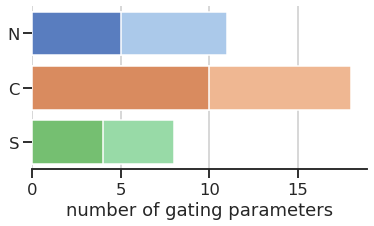

In [16]:
sns.set(style="ticks")
sns.set_context('talk')
sns.set_color_codes("pastel")

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="inact", y="model", hue="model", data=df,
            palette="pastel", dodge=False)
            #label="inact", color="b")

sns.set_color_codes("muted")
sns.barplot(x="act", y="model", hue="model", data=df,
            palette="muted", dodge=False)
            #label="act", color="r")

handles, labels = ax.get_legend_handles_labels()
order = []
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc="lower right", frameon=False)
ax.set(xlabel="number of gating parameters")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(left=True)

In [18]:
#f.savefig('figures/ito/param_num_compare.pdf')

## Compare calibration between original and unified datasets

Plot relative standard deviation (RSD) of parameter posteriors and gating functions for Nygren and Courtemanche using the original dataset and unified datasets.

Note: we use the term RSD instead of CV (coefficient of variation) to avoid confusion with conduction velocity.

#### Calculate RSD values for Nygren and Courtemanche models

In [19]:
rsd_nyg_original = weighted_cv(df_nyg_original, w_nyg_original, sample_size=len(df_nyg_original))
model = ['N',]*len(rsd_nyg_original)
data = ['ORIGINAL',]*len(rsd_nyg_original)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_original}
nyg_original = pd.DataFrame(frame)

In [20]:
rsd_nyg_unified = weighted_cv(df_nyg_unified, w_nyg_unified, sample_size=len(df_nyg_unified))
model = ['N',]*len(rsd_nyg_unified)
data = ['UNIFIED',]*len(rsd_nyg_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_unified}
nyg_unified = pd.DataFrame(frame)

In [21]:
rsd_cou_a_original = weighted_cv(df_cou_a_original, w_cou_a_original, sample_size=len(df_cou_a_original))
rsd_cou_i_original = weighted_cv(df_cou_i_original, w_cou_i_original, sample_size=len(df_cou_i_original))

rsd_cou_original = pd.concat([rsd_cou_a_original, rsd_cou_i_original])
model = ['C',]*len(rsd_cou_original)
data = ['ORIGINAL',]*len(rsd_cou_original)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_original}
cou_original = pd.DataFrame(frame)

In [22]:
rsd_cou_unified = pd.concat([rsd_cou_a_original, rsd_cou_i_original])
model = ['C',]*len(rsd_cou_unified)
data = ['UNIFIED',]*len(rsd_cou_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_unified}
cou_unified = pd.DataFrame(frame)

In [23]:
rsd_compare = pd.concat([nyg_original, nyg_unified, cou_original, cou_unified], sort=False)

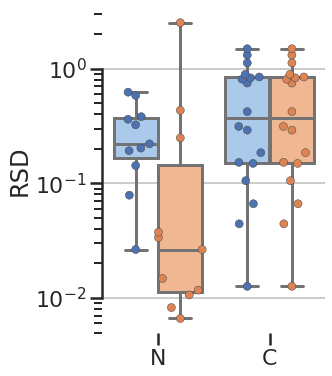

In [24]:
sns.set(style="ticks")
sns.set_context("poster")

# Initialize the figure
f, ax = plt.subplots(figsize=(4, 6))

# Plot the boxplot summary of RSD
sns.boxplot(x="model", y="RSD", hue="data", data=rsd_compare,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="model", y="RSD", hue="data", data=rsd_compare,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set_yscale('log')
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)
ax.get_legend().remove()

In [25]:
diff = nyg_unified.RSD-nyg_original.RSD
stats.wilcoxon(diff)

WilcoxonResult(statistic=18.0, pvalue=0.18231443298387762)

In [27]:
#f.savefig('figures/ito/rsd_compare.pdf')

#### Compare underlying gating functions for each model

Sample from posterior particle population and plot resulting gating functions

In [28]:
N = 100

In [29]:
nyg_par_samples_original = df_nyg_original.sample(n=N, weights=w_nyg_original, replace=True)
nyg_par_samples_original = nyg_par_samples_original.set_index([pd.Index(range(N))])
nyg_par_samples_original = nyg_par_samples_original.to_dict(orient='records')

In [30]:
nyg_par_samples_unified = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples_unified = nyg_par_samples_unified.set_index([pd.Index(range(N))])
nyg_par_samples_unified = nyg_par_samples_unified.to_dict(orient='records')

In [31]:
v = np.arange(-100, 50, 0.5)

nyg_par_map = {'ri': 'ito.r_inf',
               'rt': 'ito.tau_r',
               'si': 'ito.s_inf',
               'st': 'ito.tau_s'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


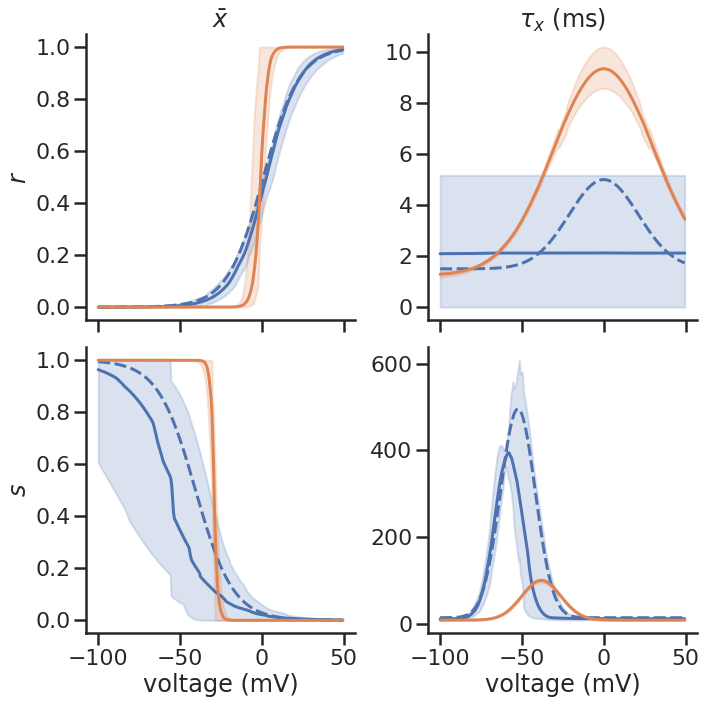

In [32]:
sns.set_context('poster')
sns.set_palette('deep')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14


f, ax = plot_variables(v, [nyg_par_map, nyg_par_map], 
                       ['models/nygren_ito.mmt', 'models/nygren_ito_.mmt'], 
                       [nyg_par_samples_original, nyg_par_samples_unified],
                       original=[True,False],
                       figshape=(2,2))

ax[0][0].set_ylabel(r'$r$')
ax[1][0].set_ylabel(r'$s$')

ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')

for a in ax[:,1].flatten():
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage (mV)')

#for a in ax[:,0]:
#    a.set_ylim((-0.05, 1.05))
    
plt.tight_layout()

In [34]:
#f.savefig('figures/ito/nyg_gating_functions.pdf')

In [35]:
cou_par_samples_a_original = df_cou_a_original.sample(n=N, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(N))])
cou_par_samples_i_original = df_cou_i_original.sample(n=N, weights=w_cou_i_original, replace=True)
cou_par_samples_i_original = cou_par_samples_i_original.set_index([pd.Index(range(N))])
cou_par_samples = (pd.concat([cou_par_samples_a_original,
                              cou_par_samples_i_original],axis=1)
                   .to_dict(orient='records'))

In [36]:
cou_par_map = {'ri': 'ito.a_inf',
               'rt': 'ito.tau_a',
               'si': 'ito.i_inf',
               'st': 'ito.tau_i'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


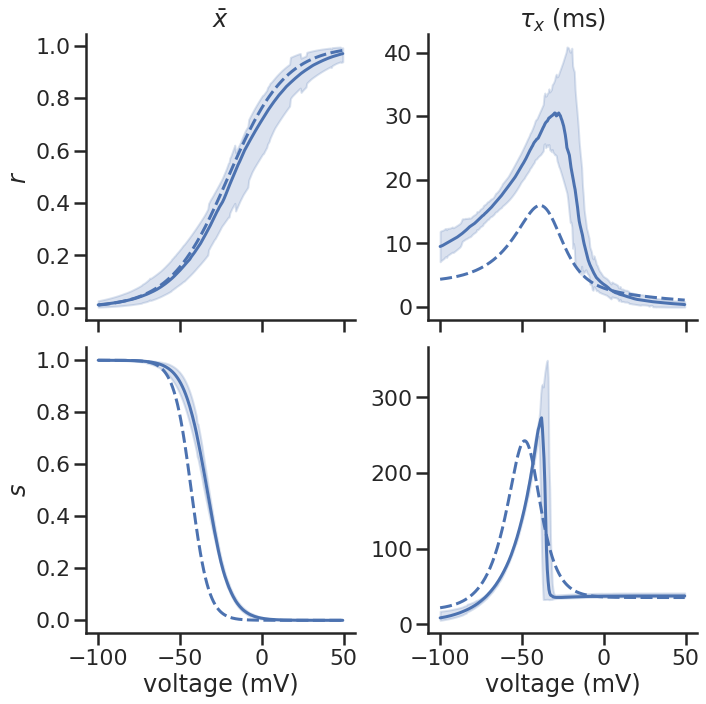

In [37]:
from ionchannelABC.visualization import plot_variables
sns.set_context('poster')
sns.set_palette('deep')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14


f, ax = plot_variables(v, [cou_par_map], 
                       ['models/courtemanche_ito.mmt'], 
                       [cou_par_samples],
                       original=[True,False],
                       figshape=(2,2))

ax[0][0].set_ylabel(r'$r$')
ax[1][0].set_ylabel(r'$s$')

ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')

for a in ax[:,1].flatten():
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage (mV)')

#for a in ax[:,0]:
#    a.set_ylim((-0.05, 1.05))
    
plt.tight_layout()

In [39]:
#f.savefig('figures/ito/cou_gating_functions.pdf')

## Compare all models calibrated to unified dataset

### RSD of parameter posteriors

In [40]:
rsd_sta = weighted_cv(df_sta, w_sta, sample_size=len(df_sta))
model = ['S',]*len(rsd_sta)
frame = {'model': model, 'RSD': rsd_sta}
sta = pd.DataFrame(frame)

In [41]:
rsd_unified = pd.concat([nyg_unified, cou_unified, sta], sort=False)

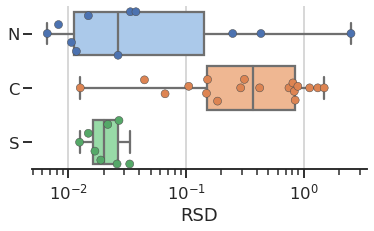

In [42]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x="RSD", y="model", data=rsd_unified,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="RSD", y="model", data=rsd_unified,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set_xscale("log")
ax.set(ylabel="")
sns.despine(left=True)

In [43]:
#f.savefig('figures/ito/rsd_compare_unified.pdf')

In [44]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=40.0, pvalue=0.3862895453617557)

In [45]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='C'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=7.0, pvalue=0.00016961862465061854)

In [46]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='C'].RSD)

MannwhitneyuResult(statistic=39.0, pvalue=0.0037439797621356898)

### Residuals to experimental data

In [47]:
N = 100

In [48]:
eps_nyg = h_nyg_unified.get_weighted_distances()

eps_nyg = eps_nyg.sample(n=N, axis=0, weights=eps_nyg.w, replace=True).distance
eps_nyg = pd.DataFrame({'model': 'N', 'eps': eps_nyg, 'exp': 'all'})

In [49]:
eps_cou_a = h_cou_a_original.get_weighted_distances()
eps_cou_i = h_cou_i_original.get_weighted_distances()
eps_cou = np.array([])
eps_cou = (np.array(eps_cou_a.sample(n=N,axis=0,weights=eps_cou_a.w,replace=True).distance) +
           np.array(eps_cou_i.sample(n=N,axis=0,weights=eps_cou_i.w,replace=True).distance))
eps_cou = pd.DataFrame({'model': 'C', 'eps': eps_cou, 'exp': 'all'})

In [50]:
eps_sta = h_sta.get_weighted_distances()
eps_sta = eps_sta.sample(n=100,axis=0,weights=eps_sta.w,replace=True).distance
eps_sta = pd.DataFrame({'model': 'S', 'eps': eps_sta, 'exp': 'all'})

In [51]:
eps = pd.concat([eps_nyg,eps_cou,eps_sta])

In [52]:
eps['normalised'] = (eps['eps']-eps['eps'].min())/(eps['eps'].max()-eps['eps'].min())

Text(0, 0.5, 'residual')

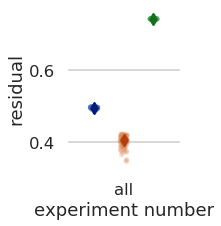

In [54]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(2, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=eps, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=eps,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.get_legend().remove()
ax.set_xlabel('experiment number')
ax.set_ylabel('residual')

In [57]:
#f.savefig('figures/ito/eps_all_stripplot.pdf')

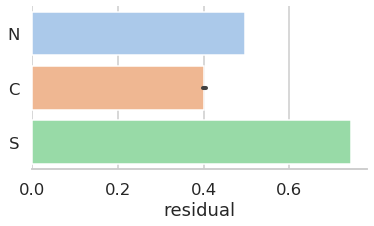

In [58]:
sns.set_context('talk')

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="eps", y="model", data=eps, palette='pastel')

ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="residual")
sns.despine(left=True)

In [60]:
#f.savefig('figures/ito/eps_all_barplot.pdf')

Below we sample from the posterior particle populations and run the calibration experiments to be able to calculate a per-experiment epsilon value.

In [61]:
N = 100

nyg_par_samples = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

cou_par_samples_a_original = df_cou_a_original.sample(n=100, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(100))])
cou_par_samples_a_original = cou_par_samples_a_original.to_dict(orient='records')

cou_par_samples_i_original = df_cou_i_original.sample(n=100, weights=w_cou_i_original, replace=True)
cou_par_samples_i_original = cou_par_samples_i_original.set_index([pd.Index(range(100))])
cou_par_samples_i_original = cou_par_samples_i_original.to_dict(orient='records')

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

In [62]:
from ionchannelABC.experiment import setup
from ionchannelABC.distance import IonChannelDistance

from experiments.ito_wang import (wang_act,
                                  wang_inact)
from experiments.ito_courtemanche import (courtemanche_act_kin,
                                          courtemanche_inact_kin,
                                          courtemanche_deact,
                                          courtemanche_rec)
experiments = [wang_act,
               courtemanche_act_kin,
               courtemanche_deact,
               wang_inact,
               courtemanche_inact_kin,
               courtemanche_rec]
models = ['models/nygren_ito_temp_adj.mmt',
          'models/courtemanche_ito_temp_adj.mmt',
          'models/standardised_ito.mmt']
pars = [nyg_par_samples, [cou_par_samples_a_original, cou_par_samples_i_original], std_par_samples]
names = ['N','C','S']

In [63]:
def experiment_dist(pars, modelfile, experiment):
    eps = []
    observ, model, sum_stats = setup(modelfile,
                                     experiment)
    obs = observ.to_dict()['y']
    obs = {str(k): v for k, v in obs.items()}
    dist = IonChannelDistance(exp_id=list(observ.exp_id),
                              variance=list(observ.variance),
                              delta=0.05)
    for sample in pars:
        eps.append(dist(sum_stats(model(sample)), obs, None))    
    return eps

__The below cell calculates the per-experiment distance and may take some time to run depending on number of samples.__

In [64]:
df = pd.DataFrame({})
mask = [None, [0, 0, 0, 1, 1, 1], None]
for j, exp in enumerate(experiments):
    df_ = pd.DataFrame({})
    for i, m in enumerate(models):
        if mask[i] is not None:
            eps = np.array(
                experiment_dist(pars[i][mask[i][j]],
                                m,
                                exp)
                )
        else:
            eps = np.array(
                experiment_dist(pars[i],
                                m,
                                exp)
                )
        df_ = df_.append(pd.DataFrame({'model': names[i],
                                       'exp': str(j),
                                       'eps': eps[~np.isinf(eps)]}))
    eps_max = df_['eps'].max()
    eps_min = df_['eps'].min()
    df_['eps'] = (df_['eps'] - eps_min)/(eps_max-eps_min)
    df = df.append(df_)

Text(0, 0.5, 'normalised residual')

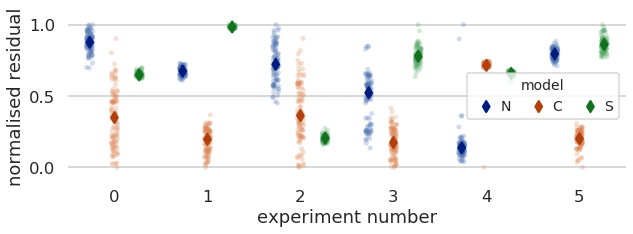

In [65]:
sns.set_context('talk')
sns.set_style('whitegrid')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize=(10, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=df, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=df,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="model",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=3, frameon=True)
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')

In [67]:
#fig.savefig('figures/ito/eps_per_exp_stripplot.pdf')

### Summary statistics compared to experimental data

In [13]:
from experiments.ito_wang import (wang_act,
                                    wang_inact)
from experiments.ito_courtemanche import (courtemanche_act_kin,
                                          courtemanche_inact_kin,
                                            courtemanche_deact,
                                            courtemanche_rec)

In [14]:
from ionchannelABC.visualization import plot_data_adjustment

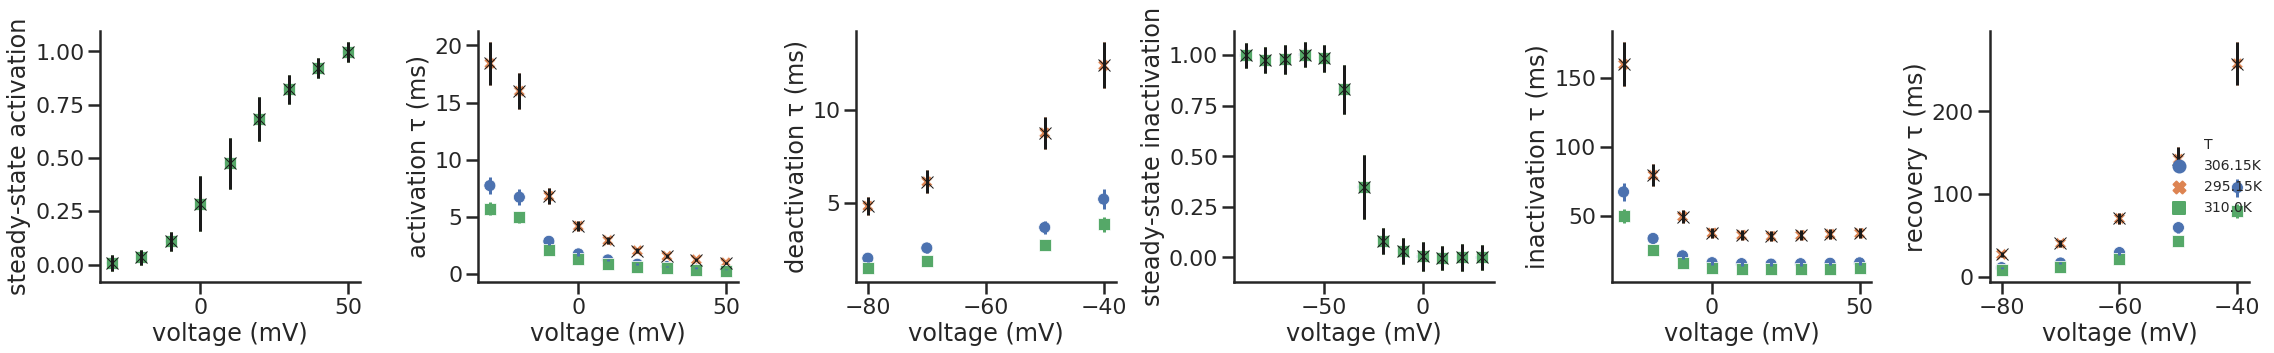

In [70]:
sns.set(style="ticks")
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_data_adjustment(['models/nygren_ito.mmt',
                          'models/courtemanche_ito.mmt',
                          'models/standardised_ito.mmt'],
                         wang_act,
                         courtemanche_act_kin,
                         courtemanche_deact,
                         wang_inact,
                         courtemanche_inact_kin,
                         courtemanche_rec)

ylabels = ["steady-state activation", "activation τ (ms)", "deactivation τ (ms)", "steady-state inactivation",
           "inactivation τ (ms)", "recovery τ (ms)"]
for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [71]:
#g.savefig('ito_data_adjustment.pdf')

In [15]:
from ionchannelABC.visualization import plot_sim_results

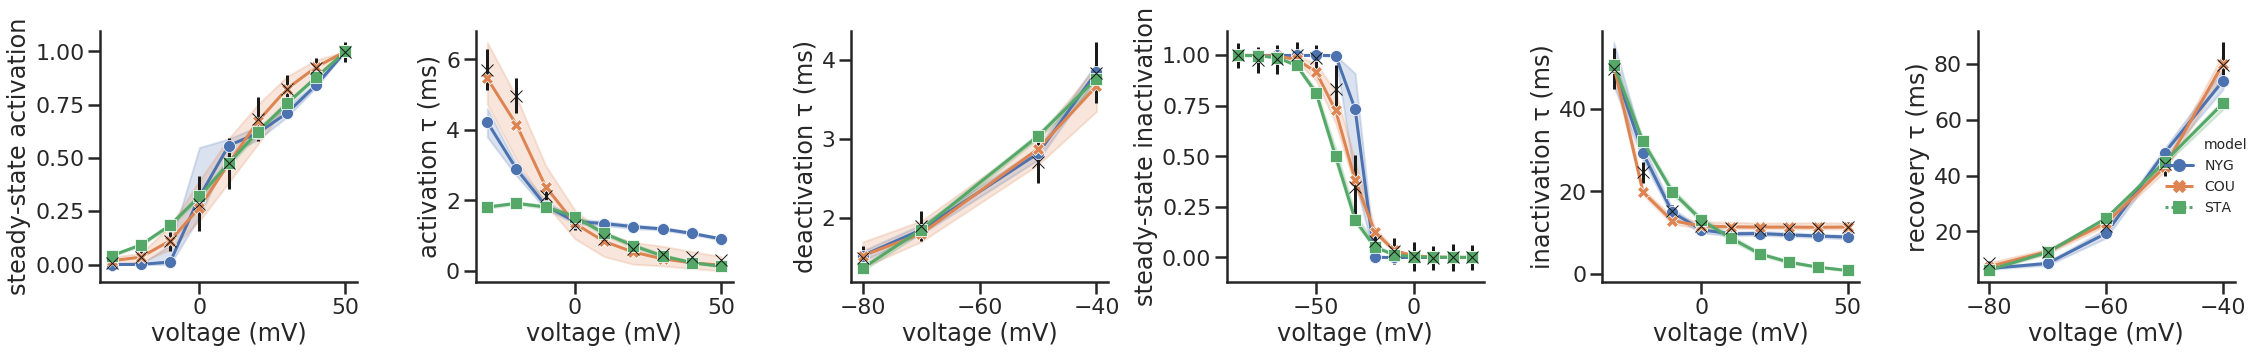

In [16]:
sns.set(style='ticks')
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(['models/nygren_ito.mmt',
                      'models/courtemanche_ito.mmt',
                      'models/courtemanche_ito.mmt',
                      'models/standardised_ito.mmt'],
                     wang_act,
                     courtemanche_act_kin,
                     courtemanche_deact,
                     wang_inact,
                     courtemanche_inact_kin,
                     courtemanche_rec,
                     temp_match_model = 3,
                     masks=[None,
                            [0,1,2]+[None,]*3,
                            [None,]*3+[3,4,5],
                            None],
                     df=[df_nyg_unified,
                         df_cou_a_original,
                         df_cou_i_original,
                         df_sta], 
                     w=[w_nyg_unified,
                        w_cou_a_original,
                        w_cou_i_original,
                        w_sta])

ylabels = ["steady-state activation", "activation τ (ms)", "deactivation τ (ms)", "steady-state inactivation",
           "inactivation τ (ms)", "recovery τ (ms)"]
for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [18]:
#g.savefig('figures/ito/compare_summary_statistics.pdf')

### Gating functions compared between models

In [13]:
nyg = 'models/nygren_ito_temp_adj.mmt'
cou ='models/courtemanche_ito_temp_adj.mmt'
std = 'models/standardised_ito.mmt'

In [14]:
v = np.arange(-80, 50, 0.5)

In [17]:
nyg_par_map = {'ri': 'ito.r_inf',
               'si': 'ito.s_inf',
               'rt': 'ito.tau_r',
               'st': 'ito.tau_s'}

cou_par_map = {'ri': 'ito.a_inf',
               'si': 'ito.i_inf',
               'rt': 'ito.tau_a',
               'st': 'ito.tau_i'}

std_par_map = {'ri': 'ito.r_ss',
               'si': 'ito.s_ss',
               'rt': 'ito.tau_r',
               'st': 'ito.tau_s'}

In [18]:
N = 100

nyg_par_samples = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

cou_par_samples_a_original = df_cou_a_original.sample(n=100, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(100))])
cou_par_samples_i_original = df_cou_i_original.sample(n=100, weights=w_cou_i_original, replace=True)
cou_par_samples_i_original = cou_par_samples_i_original.set_index([pd.Index(range(100))])
cou_par_samples = (pd.concat([cou_par_samples_a_original,
                              cou_par_samples_i_original],axis=1)
                   .to_dict(orient='records'))

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


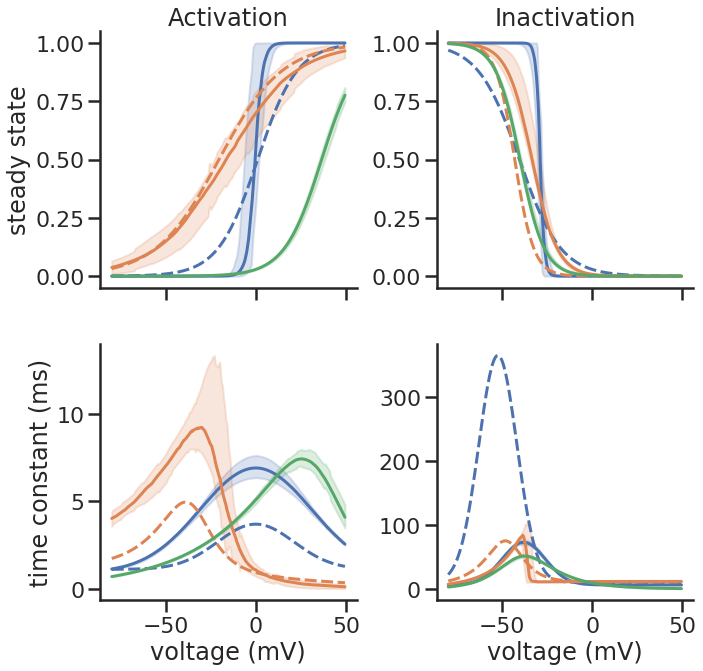

In [19]:
sns.set(style='ticks')
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_par_map, cou_par_map, std_par_map], 
                       [nyg, cou, std], 
                       [nyg_par_samples, cou_par_samples, std_par_samples],
                       original=[True, True, False],
                       figshape=(2,2))

ax[0][0].set_ylabel('steady state')
ax[1][0].set_ylabel('time constant (ms)')
ax[0][0].set_title('Activation')
ax[0][1].set_title('Inactivation')

for a in ax[0,:]:
    a.set_ylim((-0.05, 1.05))

for a in ax[:,1:].flatten():
    a.set_ylabel('')
    
for a in ax[1,:]:
    a.set_xlabel('voltage (mV)')
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
plt.tight_layout()

In [21]:
#f.savefig('figures/ito/compare_gating_functions.pdf')

### Compare final pulse after pulse train

In [83]:
import myokit

In [84]:
nsteps = 100
period = 1000
tstep = 100
vhold = -50
vstep = -10

pulsetrain = myokit.pacing.steptrain([vstep,]*nsteps,
                                     vhold,
                                     period-tstep,
                                     tstep)

In [85]:
# nygren_ina_temp_adj has had tau values adjusted for temperature to 310K
models = [myokit.load_model(modelfile) for modelfile in ['models/nygren_ito_temp_adj.mmt',
                                                         'models/courtemanche_ito_temp_adj.mmt',
                                                         'models/standardised_ito.mmt']]
for m in models:
    pace = m.get('membrane.V')
    if pace.binding() != 'pace':
        if pace.is_state():
            pace.demote()
        pace.set_rhs(0)
        pace.set_binding('pace')

In [86]:
sims = [myokit.Simulation(m, pulsetrain) for m in models]

In [87]:
par_samples = [nyg_par_samples, cou_par_samples, std_par_samples]

In [88]:
import time

all_samples = pd.DataFrame({})
for i, s in enumerate(sims):
    s.reset()
    # store original
    if models[i].name() != 'STA':
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ito.g','engine.time','membrane.V'],
                        log_interval=1)
        datalog = datalog.trim((nsteps)*period-tstep-20, (nsteps)*period, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ito.g']/max(datalog['ito.g']),
              'sample': 0,
              'model': models[i].name(),
              'type': 'original'}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)
    
    # re-calibrated
    for j, par_sample in enumerate(par_samples[i]):
        s.reset()
        for p, v in par_sample.items():
            name = p
            value = v
            if p.startswith("log"):
                name = p[4:]
                value = 10**v
            s.set_constant(name, value)
            
        # Log run time for comparisons
        t0 = time.time()
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ito.g','engine.time','membrane.V'],
                        log_interval=1)
        t1 = time.time()
        dt = t1-t0
        
        datalog = datalog.trim((nsteps)*period-tstep-20, (nsteps)*period, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ito.g']/max(datalog['ito.g']),
              'sample': j,
              'model': models[i].name(),
              'type': 'recalibrated',
              'runtime': dt}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [89]:
recalibrated_df = all_samples[all_samples['type']=='recalibrated']

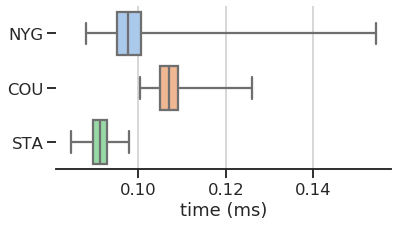

In [90]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x='runtime', y='model', data=recalibrated_df,
            palette="pastel", whis="range")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="time (ms)")
sns.despine(left=True)

In [92]:
#f.savefig('figures/ito/runtime_compare.pdf')

In [93]:
all_samples_detail = all_samples[(all_samples['time']>=19) & (all_samples['time'] < 30)]

Text(0.5, 1.0, '')

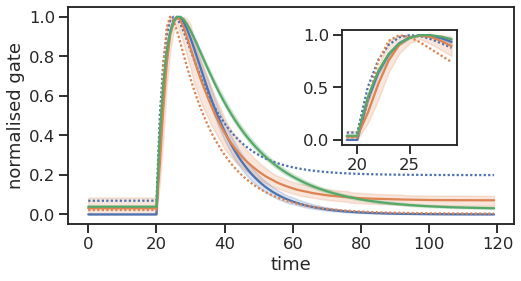

In [94]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(8,4))

g = sns.lineplot(x='time', y='gate', hue='model', style='type',
                 dashes = [(1,1),''],
                 data=all_samples, ax=ax,
                 estimator=np.median,
                 ci=None,
                 legend=False)

# plot 89% HDPI
for mi, m in enumerate(all_samples['model'].unique()):
    data = all_samples[(all_samples['model']==m) & \
                       (all_samples['type']=='recalibrated')]
    hpd = np.zeros((len(data['time'].unique()),2))
    for i, ti in enumerate(data['time'].unique()):
        di = data[data['time']==ti]
        hpd[i,:] = pymc3.stats.hpd(di['gate'], credible_interval=0.89)
    ax.fill_between(data['time'].unique(), hpd[:,0], hpd[:,1],
                    alpha=0.2, color=sns.color_palette()[mi])


ax2 = plt.axes([.6, .4, .2, .4])
sns.lineplot(x='time',y='gate',hue='model',style='type',
             dashes=[(1,1),''],
             data=all_samples_detail, ax=ax2,
             estimator=np.median,
             ci=None,
             legend=False)
# plot 89% HDPI
for mi, m in enumerate(all_samples_detail['model'].unique()):
    data = all_samples_detail[(all_samples_detail['model']==m) & \
                              (all_samples_detail['type']=='recalibrated')]
    hpd = np.zeros((len(data['time'].unique()),2))
    for i, ti in enumerate(data['time'].unique()):
        di = data[data['time']==ti]
        hpd[i,:] = pymc3.stats.hpd(di['gate'], credible_interval=0.89)
    ax2.fill_between(data['time'].unique(), hpd[:,0], hpd[:,1],
                     alpha=0.2, color=sns.color_palette()[mi])
ax2.set_xlabel('')
ax2.set_ylabel('')

ax.set_ylabel('normalised gate')
ax.set_title('')

In [96]:
#f.savefig('figures/ito/trace_compare.pdf')